# Training Loop Example

The notebook contains an example of simple training loop initialization and training.

In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import optim
from torchvision import models
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [3]:
from tqdm.autonotebook import tqdm
import pandas as pd

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import sys
from pathlib import Path
try:
    old_path
except NameError:
    old_path = sys.path.copy()
    sys.path = [Path.cwd().parent.as_posix()] + old_path

In [5]:
import re
from collections import ChainMap, OrderedDict, defaultdict

In [6]:
from loop.callbacks import History

In [7]:
def flat_model(model):
    """Converts model with nested modules into single list of modules"""
    
    def flatten(m):
        children = list(m.children())
        if not children:
            return [m]
        return sum([flatten(child) for child in children], [])
    
    return nn.Sequential(*flatten(model))

In [8]:
def as_sequential(model):
    return nn.Sequential(*list(model.children()))

In [9]:
def get_output_shape(model):
    """Pass a dummy input through the sequential model to get the output tensor shape."""
    first, *rest = flat_model(model)
    shape = first.in_channels, 128, 128
    dummy_input = torch.zeros(shape)
    out = model(dummy_input[None])
    return list(out.size())[1:]

In [10]:
class AdaptiveConcatPool2d(nn.Module):
    
    def __init__(self, size=1):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(size)
        self.max = nn.AdaptiveMaxPool2d(size)
        
    def forward(self, x):
        return torch.cat([self.max(x), self.avg(x)], 1)

In [11]:
class Flatten(nn.Module):
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [12]:
def init_default(module, init_fn=nn.init.kaiming_normal_):
    if init_fn is not None:
        if hasattr(module, 'weight'):
            init_fn(module.weight)
        if hasattr(module, 'bias') and hasattr(module.bias, 'data'):
            module.bias.data.fill_(0.)
    return module

In [13]:
def conv2d(ni, no, kernel=3, stride=1, padding=None, bias=False):
    padding = padding or kernel//2
    layer = nn.Conv2d(ni, no, kernel, stride, padding, bias=bias)
    return init_default(layer)

In [14]:
def batchnorm2d(nf):
    bn = nn.BatchNorm2d(nf)
    with torch.no_grad():
        bn.bias.fill_(1e-3)
        bn.weight.fill_(0)
    return bn

In [15]:
def init_weights(m):
    with torch.no_grad():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 1e-3)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            nn.init.zeros_(m.bias)

In [16]:
def leaky_linear(ni, no, dropout=None, bn=True):
    layers = []
    if bn:
        layers.append(nn.BatchNorm1d(ni))
    if dropout is not None and droupout > 0:
        layers.append(nn.Dropout(dropout))
    layers.append(nn.Linear(ni, no))
    layers.append(nn.LeakyReLU(0.01, True))
    return nn.Sequential(*layers)

In [17]:
class Classifier(nn.Module):
    
    def __init__(self, n_classes, arch=models.resnet18, init_fn=init_weights):
        super().__init__()
        
        model = arch(True)
        seq_model = as_sequential(model)
        backbone, classifier = seq_model[:-2], seq_model[-2:]
        out_shape = get_output_shape(backbone)
        input_size = out_shape[0] * 2
        
        self.backbone = backbone
        self.cat = AdaptiveConcatPool2d()
        self.flatten = Flatten()
        self.block1 = leaky_linear(input_size, 512)
        self.block2 = leaky_linear(512, 256)
        self.out = nn.Linear(256, n_classes)
        self.init(init_fn)
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.cat(x)
        x = self.flatten(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.out(x)
        return x
    
    def init(self, fn=None):
        if fn is None:
            return
        self.apply(fn)                

In [18]:
model = Classifier(10)

In [19]:
img = torch.zeros((4, 3, 128, 128))
out = model(img)

In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.optim import Optimizer

In [21]:
from multiprocessing import cpu_count

In [22]:
def default(x, fallback=None):
    return x if x is not None else fallback

In [23]:
def merge_dicts(ds):
    merged = OrderedDict()
    for d in ds:
        for k, v in d.items():
            merged[k] = v
    return merged

In [24]:
class Callback:
    
    def training_started(self, **kwargs):
        pass
    
    def training_ended(self, **kwargs):
        pass
    
    def epoch_started(self, **kwargs):
        pass
    
    def phase_started(self, **kwargs):
        pass

    def phase_ended(self, **kwargs):
        pass
    
    def epoch_ended(self, **kwargs):
        pass
    
    def batch_started(self, **kwargs):
        pass
    
    def batch_ended(self, **kwargs):
        pass
    
    def before_forward_pass(self, **kwargs):
        pass
    
    def after_forward_pass(self, **kwargs):
        pass
    
    def before_backward_pass(self, **kwargs):
        pass
    
    def after_backward_pass(self, **kwargs):
        pass

In [25]:
class RollingLoss(Callback):
    
    def __init__(self, smooth=0.98):
        self.smooth = smooth
    
    def batch_ended(self, phase, **kwargs):
        prev = phase.rolling_loss
        a = self.smooth
        avg_loss = a*prev + (1 - a)*phase.batch_loss
        debias_loss = avg_loss/(1 - a**phase.batch_index)
        phase.rolling_loss = avg_loss
        phase.update(debias_loss)
        
    def epoch_ended(self, phases, **kwargs):
        for phase in phases:
            phase.update_metric('loss', phase.last_loss)

In [26]:
def accuracy(out, y_true):
    y_hat = out.argmax(dim=-1).view(y_true.size(0), -1)
    y_true = y_true.view(y_true.size(0), -1)
    match = y_hat == y_true
    return match.float().mean()


class Accuracy(Callback):
    
    def epoch_started(self, **kwargs):
        self.values = defaultdict(int)
        self.counts = defaultdict(int)
        
    def batch_ended(self, phase, output, target, **kwargs):
        acc = accuracy(output, target).detach().item()
        self.counts[phase.name] += target.size(0)
        self.values[phase.name] += target.size(0) * acc
    
    def epoch_ended(self, phases, **kwargs):
        for phase in phases:
            metric = self.values[phase.name]/self.counts[phase.name]
            phase.update_metric('accuracy', metric)

In [43]:
class History(Callback):
        
    def training_started(self, **kwargs):
        self.recorded = None
        self.epochs = []
        
    def epoch_ended(self, epoch, **kwargs):
        self.epochs.append(epoch)
    
    def training_ended(self, phases, **kwargs):
        epochs = {'epoch': np.array(self.epochs).astype(int)}
        metrics = [epochs] + [phase.metrics_history for phase in phases]
        data = pd.DataFrame(merge_dicts(metrics))
        data.reset_index(inplace=True, drop=True)
        self.recorded = data
        
    def plot(self, metrics, ax=None):
        self.recorded.plot(x='epoch', y=metrics, ax=ax)

In [28]:
class StreamLogger(Callback):
    """
    Writes performance metrics collected during the training process into list
    of streams.

    Parameters:
        streams: A list of file-like objects with `write()` method.

    """
    def __init__(self, streams=None, log_every=1):
        self.streams = streams or [sys.stdout]
        self.log_every = log_every
    
    def epoch_ended(self, phases, epoch, **kwargs):
        metrics = merge_dicts([phase.last_metrics for phase in phases])
        values = [f'{k}={v:.4f}' for k, v in metrics.items()]
        values_string = ', '.join(values)
        string = f'Epoch: {epoch:4d} | {values_string}\n'
        for stream in self.streams:
            stream.write(string)
            stream.flush()

In [29]:
class ImprovementTracker(Callback):
    
    def __init__(self, patience=1, metric='valid_loss', better=min):
        self.patience = patience
        self.metric = metric
        self.better = better
        self.no_improvement = None
        self.stagnation = None
        self.best_value = None

    @property
    def improved(self):
        return self.no_improvement == 0
        
    def training_started(self, **kwargs):
        self.no_improvement = 0
        self.stagnation = False
        
    def epoch_ended(self, phases, epoch, **kwargs):
        metrics = merge_dicts([phase.last_metrics for phase in phases])
        value = metrics[self.metric]
        best_value = default(self.best_value, value)
        improved = self.better(best_value, value) == value
        if not improved:
            self.no_improvement += 1
        else:
            self.best_value = value
            self.no_improvement = 0
        if self.no_improvement >= self.patience:
            self.stagnation = True

In [30]:
class ProgressBar(Callback):
    
    def training_started(self, phases, **kwargs):
        bars = OrderedDict()
        for phase in phases:
            bars[phase.name] = tqdm(total=len(phase.loader), desc=phase.name)
        self.bars = bars
    
    def batch_ended(self, phase, **kwargs):
        bar = self.bars[phase.name]
        bar.set_postfix_str(f'loss: {phase.last_loss:.4f}')
        bar.update(1)
        bar.refresh()
        
    def epoch_ended(self, **kwargs):
        for bar in self.bars.values():
            bar.n = 0
            bar.refresh()
            
    def training_ended(self, **kwargs):
        for bar in self.bars.values():
            bar.n = bar.total
            bar.refresh()
            bar.close()

In [31]:
def to_snake_case(string):
    s = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s).lower()

In [32]:
class CallbacksGroup:
    
    def __init__(self, callbacks):
        self.callbacks = callbacks
        self.named_callbacks = {
            to_snake_case(cb.__class__.__name__): cb
            for cb in callbacks}
    
    def set_loop(self, loop):
        self.loop = loop
        
    def __getitem__(self, item):
        item = to_snake_case(item)
        if item in self.named_callbacks:
            return self.named_callbacks[item] 
        raise KeyError(f'callback name not found: {item}')
        
    def training_started(self, **kwargs):
        for cb in self.callbacks:
            cb.training_started(**kwargs)
    
    def training_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.training_ended(**kwargs)
            
    def phase_started(self, **kwargs):
        for cb in self.callbacks:
            cb.phase_started(**kwargs)

    def phase_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.phase_ended(**kwargs)
    
    def epoch_started(self, **kwargs):
        for cb in self.callbacks:
            cb.epoch_started(**kwargs)
    
    def epoch_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.epoch_ended(**kwargs)
    
    def batch_started(self, **kwargs):
        for cb in self.callbacks:
            cb.batch_started(**kwargs)
            
    def batch_ended(self, **kwargs):
        for cb in self.callbacks:
            cb.batch_ended(**kwargs)
    
    def before_forward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.before_forward_pass(**kwargs)
    
    def after_forward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.after_forward_pass(**kwargs)
    
    def before_backward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.before_forward_pass(**kwargs)
    
    def after_backward_pass(self, **kwargs):
        for cb in self.callbacks:
            cb.after_backward_pass(**kwargs)

In [33]:
class Phase:
    """
    Model training loop phase.

    Each model's training loop iteration could be separated into (at least) two
    phases: training and validation. The instances of this class track
    metrics and counters, related to the specific phase, and keep the reference
    to subset of data, used during phase.
    """
    def __init__(self, name: str, loader: DataLoader, grad: bool=True):
        self.name = name
        self.loader = loader
        self.grad = grad
        self.batch_loss = None
        self.batch_index = 0
        self.rolling_loss = 0
        self.losses = []
        self.metrics = OrderedDict()
        
    @property
    def last_loss(self):
        return self.losses[-1] if self.losses else None
    
    @property
    def last_metrics(self):
        metrics = OrderedDict()
        metrics[f'{self.name}_loss'] = self.last_loss
        for name, values in self.metrics.items():
            metrics[f'{self.name}_{name}'] = values[-1]
        return metrics
    
    @property
    def metrics_history(self):
        metrics = OrderedDict()
        for name, values in self.metrics.items():
            metrics[f'{self.name}_{name}'] = values
        return metrics

    def update(self, loss):
        self.losses.append(loss)
        
    def update_metric(self, name, value):
        if name not in self.metrics:
            self.metrics[name] = []
        self.metrics[name].append(value)

In [34]:
class ExpandChannels:
    
    def __init__(self, num_of_channels=3):
        self.nc = num_of_channels
    
    def __call__(self, x):
        return x.expand((self.nc,) + x.shape[1:])

In [35]:
def get_transforms():
    return Compose([
        ToTensor(), 
        ExpandChannels(3),
        Normalize((0.1307,), (0.3081,))
    ])

In [36]:
def place_and_unwrap(batch, dev):
    x, *y = batch
    x = x.to(dev)
    y = [tensor.to(dev) for tensor in y]
    if len(y) == 1:
        [y] = y
    return x, y

In [37]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [42]:
n = 4
n_jobs = default(n, cpu_count())
epochs = 10
batch_size = 2048
device = torch.device('cuda:1')

transforms = get_transforms()
root = Path('~/data/mnist').expanduser()
train_ds = MNIST(root, train=True, download=True, transform=transforms)
valid_ds = MNIST(root, train=False, transform=transforms)

phases = [
    Phase('train', DataLoader(train_ds, batch_size, shuffle=True)),
    Phase('valid', DataLoader(valid_ds, batch_size), grad=False)
]

# model = Classifier(10)
model = Net()
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
cb = CallbacksGroup([History(), RollingLoss(), Accuracy(), StreamLogger(), ProgressBar()])
cb.training_started(phases=phases)

for epoch in range(1, epochs + 1):
    cb.epoch_started(epoch=epoch)

    for phase in phases:
        n = len(phase.loader)
        cb.phase_started(phase=phase, total_batches=n)
        is_training = phase.grad
        model.train(is_training)
        
        for batch in phase.loader:

            phase.batch_index += 1
            cb.batch_started(phase=phase, total_batches=n)
            x, y = place_and_unwrap(batch, device)
            
            with torch.set_grad_enabled(is_training):
                cb.before_forward_pass()
                out = model(x)
                cb.after_forward_pass()
                loss = loss_fn(out, y)
            
            if is_training:
                opt.zero_grad()
                cb.before_backward_pass()
                loss.backward()
                cb.after_backward_pass()
                opt.step()
            
            phase.batch_loss = loss.item()
            cb.batch_ended(phase=phase, output=out, target=y)
            
        cb.phase_ended(phase=phase)
    
    cb.epoch_ended(phases=phases, epoch=epoch)
    
cb.training_ended(phases=phases)

Epoch:    1 | train_loss=1.6130, train_accuracy=0.4389, valid_loss=0.5320, valid_accuracy=0.8780
Epoch:    2 | train_loss=1.0082, train_accuracy=0.7791, valid_loss=0.3697, valid_accuracy=0.9392
Epoch:    3 | train_loss=0.7067, train_accuracy=0.8628, valid_loss=0.2899, valid_accuracy=0.9544
Epoch:    4 | train_loss=0.5355, train_accuracy=0.8924, valid_loss=0.2403, valid_accuracy=0.9637
Epoch:    5 | train_loss=0.4294, train_accuracy=0.9079, valid_loss=0.2069, valid_accuracy=0.9682
Epoch:    6 | train_loss=0.3623, train_accuracy=0.9161, valid_loss=0.1825, valid_accuracy=0.9711
Epoch:    7 | train_loss=0.3144, train_accuracy=0.9245, valid_loss=0.1636, valid_accuracy=0.9741
Epoch:    8 | train_loss=0.2822, train_accuracy=0.9294, valid_loss=0.1483, valid_accuracy=0.9752
Epoch:    9 | train_loss=0.2563, train_accuracy=0.9351, valid_loss=0.1356, valid_accuracy=0.9781
Epoch:   10 | train_loss=0.2372, train_accuracy=0.9379, valid_loss=0.1249, valid_accuracy=0.9787




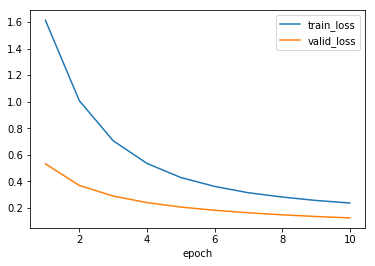

In [44]:
cb['history'].plot(['train_loss', 'valid_loss'])

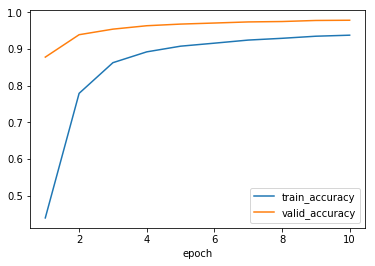

In [45]:
cb['history'].plot(['train_accuracy', 'valid_accuracy'])